In [90]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
import argparse
import gc
import os
import pickle as pkl
import random
import sys
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

#input_path = Path('D:/SIGIR/train/')
input_path = Path('/content/drive/MyDrive/Data_Competitions/SIGIR2021/')

In [92]:
from sklearn.decomposition import PCA

In [93]:
meta_df = pd.read_csv(input_path / 'sku_to_content.csv')

In [94]:
pd.options.display.max_columns = 100

In [95]:
meta_df

,product_sku_hash,description_vector,category_hash,image_vector,price_bucket
0,26ce7b47f4c46e4087e83e54d2f7ddc7ea57862fed2e2a...,NaN,NaN,NaN,NaN
1,6383992be772b204a9ab75f86c86f5583d1bdd1222952d...,NaN,NaN,NaN,NaN
2,a2c3e2430c6ef9770b903ad08fa067a6b2b9db28f06e1b...,"[0.27629122138023376, -0.15763211250305176, 0....",06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,"[340.3592564184389, -220.19025864725685, 154.0...",7.0
3,1028ef615e425c328e7b95010dfb1fb93cf63749a1bc80...,"[0.4058118760585785, -0.03595402091741562, 0.2...",115a6a7017ee55752b8487c77dfde92b0d501d10a2e69c...,"[180.3463662921092, 222.702322343354, -8.88703...",8.0
4,9870c682d0d52d635501249da0eeaa118fad430b695ea1...,"[-0.3206155300140381, 0.01991105079650879, 0.0...",0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,"[-114.81079301576219, 84.55770104232334, 85.51...",2.0
...,...,...,...,...,...
66381,c7cc673ca3baa5fa222fffdc16379892b3a62583a48143...,NaN,NaN,NaN,NaN
66382,6641c7d2053ce48ce1e81a9653dffe56dbb79ab0704fbd...,"[-0.19150441884994507, -0.06235162168741226, -...",0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,"[129.55668732976045, 43.27996741934932, -36.70...",3.0
66383,526a6a51717d5bb40ef2b0c47394d08c54385375633bab...,"[-0.19760936498641968, 0.4446450471878052, -0....",0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,"[-158.25984189321855, 74.19255741438077, 199.6...",5.0
66384,21ca4ab0e2fbd3b401fbeadeb4439dcab9998fb52159ec...,NaN,NaN,NaN,NaN


# description

In [96]:
meta_df['description_vector_cleaned'] = meta_df['description_vector'].str.replace('[,\[\]]', '')
meta_df['description_vector_cleaned']

0                                                      NaN
1                                                      NaN
2        0.27629122138023376 -0.15763211250305176 0.204...
3        0.4058118760585785 -0.03595402091741562 0.2274...
4        -0.3206155300140381 0.01991105079650879 0.0125...
                               ...                        
66381                                                  NaN
66382    -0.19150441884994507 -0.06235162168741226 -0.0...
66383    -0.19760936498641968 0.4446450471878052 -0.108...
66384                                                  NaN
66385                                                  NaN
Name: description_vector_cleaned, Length: 66386, dtype: object

In [97]:
dscrp = meta_df['description_vector_cleaned'].str.split(' ', expand=True)
dscrp = dscrp.dropna(how='any')
dscrp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
2,0.27629122138023376,-0.15763211250305176,0.20498991012573242,0.14392423629760742,0.02859744429588318,0.032556530088186264,0.0425204336643219,0.048966649919748306,-0.005429103970527649,-0.15156537294387817,-0.0761469304561615,0.008084282279014587,0.16259127855300903,0.06268741190433502,0.07540282607078552,-0.14114734530448914,0.032842863351106644,0.05774400383234024,0.01570936292409897,0.0791906863451004,0.044912777841091156,0.08371087163686752,0.012448647990822792,0.02274206466972828,-0.008040498942136765,0.02965005487203598,-0.01073429174721241,-0.10582432895898819,-0.0049352035857737064,0.02189919725060463,0.05689143389463425,-0.06139263138175011,0.0058634416200220585,-0.040987320244312286,0.022118519991636276,0.013095390051603317,-0.03030797839164734,-0.06476592272520065,-0.036668576300144196,0.006767163518816233,-0.07804811000823975,-0.0834140032529831,0.032515641301870346,0.0027643367648124695,-0.03663724660873413,0.03451046720147133,-0.008565815165638924,0.013749184086918831,-0.06541545689105988,0.029340581968426704
3,0.4058118760585785,-0.03595402091741562,0.2274164855480194,-0.0020155813544988632,-0.1110837534070015,-0.0637422651052475,0.13396981358528137,-0.02796291559934616,0.08489670604467392,0.026193639263510704,0.01661023683845997,-0.008063038811087608,-0.09224934875965118,0.014150758273899555,0.0288272425532341,-0.07577403634786606,-0.03546998277306557,-0.06944875419139862,0.06689142435789108,0.027035702019929886,-0.05544603243470192,0.01554050575941801,0.040030643343925476,-0.05152808874845505,-0.010175680741667747,0.048867277801036835,-0.081000417470932,0.06687279790639877,-0.053481318056583405,0.012298863381147385,0.051112327724695206,-0.015247642062604427,-0.020677708089351654,-0.04481849819421768,0.009805622510612011,0.01845768466591835,-0.01903180591762066,-0.03637757897377014,-0.012448285706341267,-0.09328916668891907,-0.01947801560163498,0.027211369946599007,0.07338394224643707,0.008180874399840832,0.031826574355363846,-0.060008272528648376,0.035343706607818604,-0.051137715578079224,0.012393627315759659,-0.03280340135097504
4,-0.3206155300140381,0.01991105079650879,0.012587778270244598,-0.323910653591156,0.20413319766521454,-0.03314844146370888,0.09954024851322174,-0.16137036681175232,-0.04882458969950676,-0.04503757506608963,-0.08505879342556,0.002115321345627308,0.0379120334982872,-0.08126094192266464,-2.3199710994958878e-05,0.1304796040058136,0.03854574263095856,0.16611988842487335,-0.0575147308409214,-0.14036822319030762,0.036785855889320374,0.03890655189752579,-0.04348204284906387,0.08287549018859863,0.0243816040456295,0.0054317438043653965,0.023287486284971237,-0.05643916875123978,0.05699824541807175,0.08238320797681808,0.10293243825435638,0.094457246363163,-0.044721223413944244,-0.02680319733917713,-0.026570338755846024,0.0016995295882225037,0.023316815495491028,-0.06468257308006287,-9.71602275967598e-06,-0.013617167249321938,-0.043855953961610794,-0.010623747482895851,-0.048465777188539505,-0.04709893837571144,0.017600947991013527,-0.09571988135576248,-0.03160473704338074,0.004239215515553951,0.014840751886367798,-0.008137889206409454
7,-0.1854386031627655,0.19424490630626678,-0.014417765662074089,-0.015076628886163235,-0.15314951539039612,-0.05724025517702103,0.004806802608072758,0.03654219210147858,0.002532588317990303,0.027012336999177933,-0.04982634633779526,-0.009720289148390293,0.01913185976445675,-0.047593988478183746,0.02513815090060234,-0.010744486004114151,-0.06697773933410645,0.026114730164408684,-0.0010108330752700567,0.0036389795131981373,0.006632043980062008,0.021944748237729073,0.0005855984054505825,-0.004378866404294968,0.023324690759181976,0.016348309814929962,-0.01510295458137989,-0.025048907846212387,-0.03246193751692772,-0.02340652048587799,0.00030769407749176025,-0.014006010256707668,0.028818286955356598,0.0165716465562582,0.02049604244

In [98]:
def pca(data, k=50):
    pca = PCA(n_components=k)
    pca.fit(data)
    feature = pca.transform(data)
    expl_var = pca.explained_variance_ratio_
    return feature, expl_var

In [99]:
feature_description, expl_var_description = pca(dscrp)

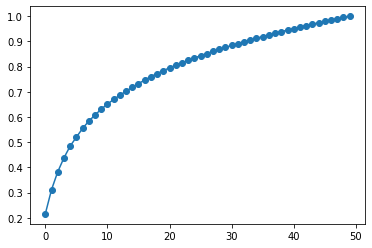

In [100]:
plt.plot(np.cumsum(expl_var_description), "-o")

In [101]:
feature_description.shape

(31950, 50)

In [102]:
def get_feature_df(feature, name='feature', k=4):
    feature = pd.DataFrame(feature[:,:k])
    feature.columns = [f'{name}_{i}' for i in feature.columns]
    return feature

In [103]:
description_df = get_feature_df(feature_description, 'description')
description_df

,description_0,description_1,description_2,description_3
0,0.289066,0.159465,0.205756,0.133696
1,0.412264,0.025031,0.208826,-0.016461
2,-0.320544,0.006260,0.004190,-0.318254
3,-0.197082,-0.185781,0.000509,-0.022563
4,-0.248925,0.140452,-0.075396,-0.119166
...,...,...,...,...
31945,-0.229579,0.165899,0.017086,0.239474
31946,-0.151732,-0.340353,0.013589,0.147705
31947,-0.184370,-0.164997,-0.020568,-0.017117
31948,-0.197100,0.073515,-0.051075,-0.186056


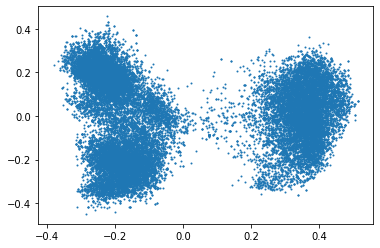

In [104]:
plt.scatter(description_df['description_0'], description_df['description_1'], s=1)

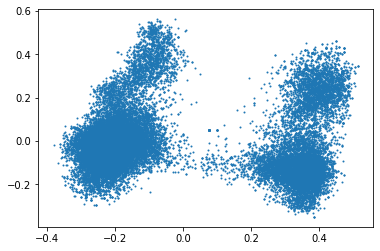

In [105]:
plt.scatter(description_df['description_0'], description_df['description_2'], s=1)

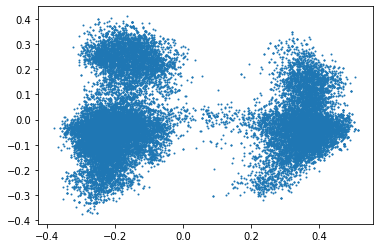

In [106]:
plt.scatter(description_df['description_0'], description_df['description_3'], s=1)

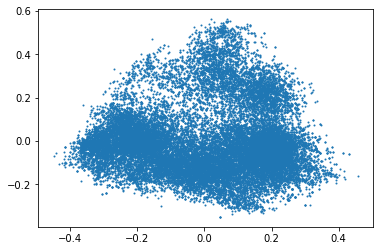

In [107]:
plt.scatter(description_df['description_1'], description_df['description_2'], s=1)

In [110]:
description_df = description_df / description_df.std()

In [111]:
for c in description_df.columns:
    meta_df[c] = np.nan
    meta_df.loc[~meta_df['description_vector'].isnull(), c] = description_df[c].values

In [112]:
meta_df

,product_sku_hash,description_vector,category_hash,image_vector,price_bucket,description_vector_cleaned,description_0,description_1,description_2,description_3
0,26ce7b47f4c46e4087e83e54d2f7ddc7ea57862fed2e2a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6383992be772b204a9ab75f86c86f5583d1bdd1222952d...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a2c3e2430c6ef9770b903ad08fa067a6b2b9db28f06e1b...,"[0.27629122138023376, -0.15763211250305176, 0....",06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,"[340.3592564184389, -220.19025864725685, 154.0...",7.0,0.27629122138023376 -0.15763211250305176 0.204...,1.068909,0.883426,1.324272,0.974608
3,1028ef615e425c328e7b95010dfb1fb93cf63749a1bc80...,"[0.4058118760585785, -0.03595402091741562, 0.2...",115a6a7017ee55752b8487c77dfde92b0d501d10a2e69c...,"[180.3463662921092, 222.702322343354, -8.88703...",8.0,0.4058118760585785 -0.03595402091741562 0.2274...,1.524474,0.138673,1.344033,-0.119996
4,9870c682d0d52d635501249da0eeaa118fad430b695ea1...,"[-0.3206155300140381, 0.01991105079650879, 0.0...",0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,"[-114.81079301576219, 84.55770104232334, 85.51...",2.0,-0.3206155300140381 0.01991105079650879 0.0125...,-1.185310,0.034680,0.026970,-2.319981
...,...,...,...,...,...,...,...,...,...,...
66381,c7cc673ca3baa5fa222fffdc16379892b3a62583a48143...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66382,6641c7d2053ce48ce1e81a9653dffe56dbb79ab0704fbd...,"[-0.19150441884994507, -0.06235162168741226, -...",0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,"[129.55668732976045, 43.27996741934932, -36.70...",3.0,-0.19150441884994507 -0.06235162168741226 -0.0...,-0.728838,0.407270,-0.328725,-1.356297
66383,526a6a51717d5bb40ef2b0c47394d08c54385375633bab...,"[-0.19760936498641968, 0.4446450471878052, -0....",0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,"[-158.25984189321855, 74.19255741438077, 199.6...",5.0,-0.19760936498641968 0.4446450471878052 -0.108...,-0.825549,-2.347586,-0.646102,-1.805299
66384,21ca4ab0e2fbd3b401fbeadeb4439dcab9998fb52159ec...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# image

In [113]:
meta_df['img_vector_cleaned'] = meta_df['image_vector'].str.replace('[,\[\]]', '')
meta_df['img_vector_cleaned']

0                                                      NaN
1                                                      NaN
2        340.3592564184389 -220.19025864725685 154.0858...
3        180.3463662921092 222.702322343354 -8.88703259...
4        -114.81079301576219 84.55770104232334 85.51753...
                               ...                        
66381                                                  NaN
66382    129.55668732976045 43.27996741934932 -36.70753...
66383    -158.25984189321855 74.19255741438077 199.6185...
66384                                                  NaN
66385                                                  NaN
Name: img_vector_cleaned, Length: 66386, dtype: object

In [114]:
img = meta_df['img_vector_cleaned'].str.split(' ', expand=True)
img = img.dropna(how='any')
img

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
2,340.3592564184389,-220.19025864725685,154.08589911634107,54.613051997634415,58.25951372631849,94.59602356444196,115.5546297632157,100.8790425830826,-59.62565875126851,59.17217189522084,-69.90354735324398,-13.643084833661671,-20.925769883225794,91.67353936394562,-73.14549038302759,86.31523373310287,35.28784261255909,129.162690792141,-76.35999632844582,44.192701280848894,-29.706338693439115,-11.812866154722444,98.44367864453986,10.744801944140775,10.934785979371423,7.996371529503798,4.211931642715507,10.0455261822466,11.086967189594343,0.14021891923964347,13.359575259817777,-35.115868916377025,-20.201591013635404,16.19069682926293,-69.23046580593561,-24.911955858990588,-2.5991547104742434,13.004824589176527,-15.701478529226732,-14.783676995904763,46.99732924004995,-7.695001829783383,-6.140431030396864,41.50459974761075,-98.17476036245894,-16.196734442697156,29.72265431542192,-30.881698824388177,54.33105446621461,0.6460993347180128
3,180.3463662921092,222.702322343354,-8.887032592587131,-37.7069266551799,-13.273460236820249,-4.147120824214516,83.91175404484609,-211.2093118742191,81.1827697271972,-33.07784352049952,183.8775490712008,-127.6296340920946,-138.024784991449,-6.711958626242123,-73.62318085473171,-108.73452932386812,7.4398194287692405,32.559372007183995,92.92102185051282,94.06236467323222,-11.146237966183858,-4.87347288566921,23.251083102807865,-6.268094033062299,-14.27696980538991,95.72813195776804,-50.83831260400642,-17.483212636608407,1.2991259064802283,31.864766457174,-125.5489713479327,-61.86204706288282,113.68531052420316,-11.391328610896311,-26.384444757644392,-58.91897162175617,-21.119701812788538,77.16223701095997,15.773672251425449,-5.999823837098637,-4.749580748527556,19.68204750217188,93.71005702095547,-26.826409315088593,19.141971869036524,8.449246006712524,46.65187095175591,-21.510748637506232,22.190161246854778,-35.57994134340289
4,-114.81079301576219,84.55770104232334,85.51753099059488,-18.088053441755385,-4.060084279785439,-9.591500388169116,105.57546186898325,-6.397733244588725,42.01109623785901,33.90742506412957,55.050595004187215,-23.271091754310333,35.90983885488038,-31.14004882709796,-11.586262346923231,31.648118295246515,14.224197318887796,-70.59979580909362,-33.026475932109165,-55.48934023470133,0.020000490267833904,15.527217811671592,36.36456716305914,-54.67079725997027,-45.37288078335403,21.488157596308735,-31.63131364279802,-57.08086858889976,39.81920910280961,11.678554056118749,44.03212720485901,7.83744741854732,-36.19326571580306,-11.591644939038218,59.99453552825405,-20.19077269928696,73.2132772212778,-1.164818595320643,41.7011536326781,32.38126267017978,25.63314309253754,19.82320734688758,-6.003224440719562,10.89389218569002,32.24699283103098,-9.935189695490653,68.00385863720555,22.11285900353412,-8.380134462429158,-1.2806911634425637
7,-136.92241034233342,38.10508984596936,55.68365512302937,-1.0093360489101322,-5.47640737135739,10.64570778285564,29.21382438828813,96.83210274335873,-17.3959835769816,-76.2855005055067,-119.05935843227083,43.175018851171714,-25.33385579511751,5.26639255830187,24.239160381661378,-61.67193001097675,44.16226021854306,23.75344965748971,50.023229534705514,-59.60192652982015,33.85752076732377,-74.29647677224483,49.53327095343383,-25.328688082052416,22.822382730007487,39.21392607072102,-9.29435232586501,-95.24389144318023,12.735114610196135,-7.756426158427437,63.389752526012686,-23.893097362804546,12.913358305578875,37.25224357487831,29.331756655540875,-62.88261816596793,3.7200266949775127,68.3450830253675,46.176393208745246,46.80598298667609,-9.813768688728063,-32.202601541429374,-10.045028040005453,40.27632774727505,-0.35112824302361645,-35.68618063606554,9.15733945918771,5.690118636054649,-27.337586824202674,21.372772858888055
10,-176.43381730762223,185.29138615399393,121.55798001818448,16.18659405511915,-156.9696116785757

In [115]:
feature_img, expl_var_img = pca(img)

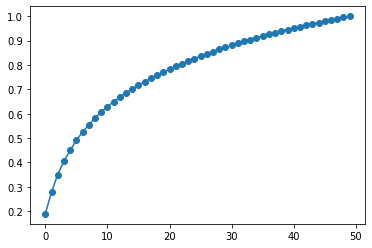

In [116]:
plt.plot(np.cumsum(expl_var_img), "-o")

In [117]:
img_df = get_feature_df(feature_img, 'img')
img_df

,img_0,img_1,img_2,img_3
0,331.711627,-241.419186,139.160553,50.344854
1,185.405067,221.300313,9.199115,-36.905042
2,-115.722543,78.819839,91.061894,-18.718953
3,-138.663021,34.169740,58.493665,-1.223665
4,-174.162905,179.857934,135.179515,12.197671
...,...,...,...,...
28365,394.222086,-229.284004,115.486925,41.402077
28366,-234.117859,25.066815,37.194320,14.944388
28367,-228.695574,-30.792078,-48.413564,188.036971
28368,129.659196,42.481905,-33.664028,-121.242961


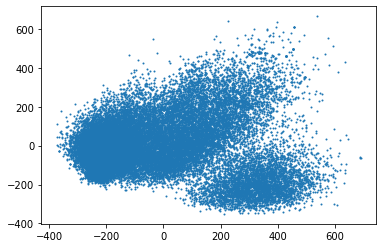

In [118]:
plt.scatter(img_df['img_0'], img_df['img_1'], s=1)

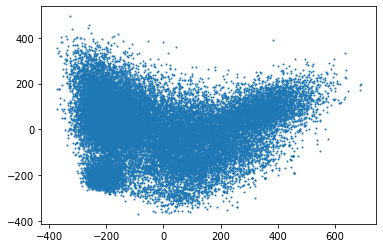

In [119]:
plt.scatter(img_df['img_0'], img_df['img_2'], s=1)

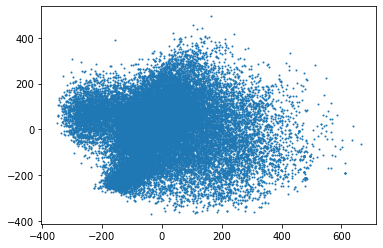

In [120]:
plt.scatter(img_df['img_1'], img_df['img_2'], s=1)

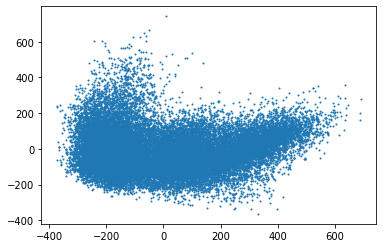

In [121]:
plt.scatter(img_df['img_0'], img_df['img_3'], s=1)

In [122]:
img_df.std()

img_0    215.933483
img_1    148.824787
img_2    133.147104
img_3    115.981458
dtype: float64

In [124]:
img_df.mean()

img_0    8.895090e-18
img_1    2.066455e-17
img_2   -5.549158e-18
img_3   -1.593524e-17
dtype: float64

In [123]:
img_df = img_df / img_df.std()

In [125]:
for c in img_df.columns:
    meta_df[c] = np.nan
    meta_df.loc[~meta_df['image_vector'].isnull(), c] = img_df[c].values

In [126]:
meta_df

,product_sku_hash,description_vector,category_hash,image_vector,price_bucket,description_vector_cleaned,description_0,description_1,description_2,description_3,img_vector_cleaned,img_0,img_1,img_2,img_3
0,26ce7b47f4c46e4087e83e54d2f7ddc7ea57862fed2e2a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6383992be772b204a9ab75f86c86f5583d1bdd1222952d...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a2c3e2430c6ef9770b903ad08fa067a6b2b9db28f06e1b...,"[0.27629122138023376, -0.15763211250305176, 0....",06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,"[340.3592564184389, -220.19025864725685, 154.0...",7.0,0.27629122138023376 -0.15763211250305176 0.204...,1.068909,0.883426,1.324272,0.974608,340.3592564184389 -220.19025864725685 154.0858...,1.536175,-1.622171,1.045164,0.434077
3,1028ef615e425c328e7b95010dfb1fb93cf63749a1bc80...,"[0.4058118760585785, -0.03595402091741562, 0.2...",115a6a7017ee55752b8487c77dfde92b0d501d10a2e69c...,"[180.3463662921092, 222.702322343354, -8.88703...",8.0,0.4058118760585785 -0.03595402091741562 0.2274...,1.524474,0.138673,1.344033,-0.119996,180.3463662921092 222.702322343354 -8.88703259...,0.858621,1.486986,0.069090,-0.318198
4,9870c682d0d52d635501249da0eeaa118fad430b695ea1...,"[-0.3206155300140381, 0.01991105079650879, 0.0...",0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,"[-114.81079301576219, 84.55770104232334, 85.51...",2.0,-0.3206155300140381 0.01991105079650879 0.0125...,-1.185310,0.034680,0.026970,-2.319981,-114.81079301576219 84.55770104232334 85.51753...,-0.535918,0.529615,0.683919,-0.161396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66381,c7cc673ca3baa5fa222fffdc16379892b3a62583a48143...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66382,6641c7d2053ce48ce1e81a9653dffe56dbb79ab0704fbd...,"[-0.19150441884994507, -0.06235162168741226, -...",0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,"[129.55668732976045, 43.27996741934932, -36.70...",3.0,-0.19150441884994507 -0.06235162168741226 -0.0...,-0.728838,0.407270,-0.328725,-1.356297,129.55668732976045 43.27996741934932 -36.70753...,0.600459,0.285449,-0.252833,-1.045365
66383,526a6a51717d5bb40ef2b0c47394d08c54385375633bab...,"[-0.19760936498641968, 0.4446450471878052, -0....",0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,"[-158.25984189321855, 74.19255741438077, 199.6...",5.0,-0.19760936498641968 0.4446450471878052 -0.108...,-0.825549,-2.347586,-0.646102,-1.805299,-158.25984189321855 74.19255741438077 199.6185...,-0.741857,0.419055,1.497953,-1.480755
66384,21ca4ab0e2fbd3b401fbeadeb4439dcab9998fb52159ec...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# fillna

In [127]:
meta_df['price_null'] = meta_df['price_bucket'].isnull()
meta_df['description_null'] = meta_df['description_vector'].isnull()
meta_df['img_null'] = meta_df['image_vector'].isnull()

In [128]:
meta_df.loc[meta_df['category_hash'].isnull(), 'category_hash'] = -1

In [129]:
meta_df.mean()

price_bucket        5.491822e+00
description_0       1.515046e-18
description_1      -3.316422e-17
description_2      -1.876433e-19
description_3       2.022378e-18
img_0               8.895090e-18
img_1               2.066455e-17
img_2              -5.549158e-18
img_3              -1.593524e-17
price_null          5.173982e-01
description_null    5.187238e-01
img_null            5.726509e-01
dtype: float64

In [130]:
meta_df['price_bucket'].fillna(meta_df['price_bucket'].mean(), inplace=True)

In [131]:
for i in range(4):
    meta_df[f'description_{i}'].fillna(meta_df[f'description_{i}'].mean(), inplace=True)
    meta_df[f'img_{i}'].fillna(meta_df[f'img_{i}'].mean(), inplace=True)

In [132]:
meta_df

,product_sku_hash,description_vector,category_hash,image_vector,price_bucket,description_vector_cleaned,description_0,description_1,description_2,description_3,img_vector_cleaned,img_0,img_1,img_2,img_3,price_null,description_null,img_null
0,26ce7b47f4c46e4087e83e54d2f7ddc7ea57862fed2e2a...,NaN,-1,NaN,5.491822,NaN,1.515046e-18,-3.316422e-17,-1.876433e-19,2.022378e-18,NaN,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,True,True,True
1,6383992be772b204a9ab75f86c86f5583d1bdd1222952d...,NaN,-1,NaN,5.491822,NaN,1.515046e-18,-3.316422e-17,-1.876433e-19,2.022378e-18,NaN,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,True,True,True
2,a2c3e2430c6ef9770b903ad08fa067a6b2b9db28f06e1b...,"[0.27629122138023376, -0.15763211250305176, 0....",06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,"[340.3592564184389, -220.19025864725685, 154.0...",7.000000,0.27629122138023376 -0.15763211250305176 0.204...,1.068909e+00,8.834255e-01,1.324272e+00,9.746077e-01,340.3592564184389 -220.19025864725685 154.0858...,1.536175e+00,-1.622171e+00,1.045164e+00,4.340767e-01,False,False,False
3,1028ef615e425c328e7b95010dfb1fb93cf63749a1bc80...,"[0.4058118760585785, -0.03595402091741562, 0.2...",115a6a7017ee55752b8487c77dfde92b0d501d10a2e69c...,"[180.3463662921092, 222.702322343354, -8.88703...",8.000000,0.4058118760585785 -0.03595402091741562 0.2274...,1.524474e+00,1.386727e-01,1.344033e+00,-1.199957e-01,180.3463662921092 222.702322343354 -8.88703259...,8.586212e-01,1.486986e+00,6.908986e-02,-3.181978e-01,False,False,False
4,9870c682d0d52d635501249da0eeaa118fad430b695ea1...,"[-0.3206155300140381, 0.01991105079650879, 0.0...",0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,"[-114.81079301576219, 84.55770104232334, 85.51...",2.000000,-0.3206155300140381 0.01991105079650879 0.0125...,-1.185310e+00,3.467957e-02,2.697006e-02,-2.319981e+00,-114.81079301576219 84.55770104232334 85.51753...,-5.359175e-01,5.296150e-01,6.839195e-01,-1.613961e-01,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66381,c7cc673ca3baa5fa222fffdc16379892b3a62583a48143...,NaN,-1,NaN,5.491822,NaN,1.515046e-18,-3.316422e-17,-1.876433e-19,2.022378e-18,NaN,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,True,True,True
66382,6641c7d2053ce48ce1e81a9653dffe56dbb79ab0704fbd...,"[-0.19150441884994507, -0.06235162168741226, -...",0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,"[129.55668732976045, 43.27996741934932, -36.70...",3.000000,-0.19150441884994507 -0.06235162168741226 -0.0...,-7.288378e-01,4.072705e-01,-3.287253e-01,-1.356297e+00,129.55668732976045 43.27996741934932 -36.70753...,6.004590e-01,2.854491e-01,-2.528333e-01,-1.045365e+00,False,False,False
66383,526a6a51717d5bb40ef2b0c47394d08c54385375633bab...,"[-0.19760936498641968, 0.4446450471878052, -0....",0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,"[-158.25984189321855, 74.19255741438077, 199.6...",5.000000,-0.19760936498641968 0.4446450471878052 -0.108...,-8.255487e-01,-2.347586e+00,-6.461021e-01,-1.805299e+00,-158.25984189321855 74.19255741438077 199.6185...,-7.418570e-01,4.190546e-01,1.497953e+00,-1.480755e+00,False,False,False
66384,21ca4ab0e2fbd3b401fbeadeb4439dcab9998fb52159ec...,NaN,-1,NaN,5.491822,NaN,1.515046e-18,-3.316422e-17,-1.876433e-19,2.022378e-18,NaN,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,True,True,True


In [133]:
for c in ['description_vector', 'description_vector_cleaned', 'image_vector', 'img_vector_cleaned']:
    if c in meta_df.columns:
        del meta_df[c]

In [134]:
meta_df

,product_sku_hash,category_hash,price_bucket,description_0,description_1,description_2,description_3,img_0,img_1,img_2,img_3,price_null,description_null,img_null
0,26ce7b47f4c46e4087e83e54d2f7ddc7ea57862fed2e2a...,-1,5.491822,1.515046e-18,-3.316422e-17,-1.876433e-19,2.022378e-18,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,True,True,True
1,6383992be772b204a9ab75f86c86f5583d1bdd1222952d...,-1,5.491822,1.515046e-18,-3.316422e-17,-1.876433e-19,2.022378e-18,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,True,True,True
2,a2c3e2430c6ef9770b903ad08fa067a6b2b9db28f06e1b...,06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,7.000000,1.068909e+00,8.834255e-01,1.324272e+00,9.746077e-01,1.536175e+00,-1.622171e+00,1.045164e+00,4.340767e-01,False,False,False
3,1028ef615e425c328e7b95010dfb1fb93cf63749a1bc80...,115a6a7017ee55752b8487c77dfde92b0d501d10a2e69c...,8.000000,1.524474e+00,1.386727e-01,1.344033e+00,-1.199957e-01,8.586212e-01,1.486986e+00,6.908986e-02,-3.181978e-01,False,False,False
4,9870c682d0d52d635501249da0eeaa118fad430b695ea1...,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,2.000000,-1.185310e+00,3.467957e-02,2.697006e-02,-2.319981e+00,-5.359175e-01,5.296150e-01,6.839195e-01,-1.613961e-01,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66381,c7cc673ca3baa5fa222fffdc16379892b3a62583a48143...,-1,5.491822,1.515046e-18,-3.316422e-17,-1.876433e-19,2.022378e-18,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,True,True,True
66382,6641c7d2053ce48ce1e81a9653dffe56dbb79ab0704fbd...,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,3.000000,-7.288378e-01,4.072705e-01,-3.287253e-01,-1.356297e+00,6.004590e-01,2.854491e-01,-2.528333e-01,-1.045365e+00,False,False,False
66383,526a6a51717d5bb40ef2b0c47394d08c54385375633bab...,0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,5.000000,-8.255487e-01,-2.347586e+00,-6.461021e-01,-1.805299e+00,-7.418570e-01,4.190546e-01,1.497953e+00,-1.480755e+00,False,False,False
66384,21ca4ab0e2fbd3b401fbeadeb4439dcab9998fb52159ec...,-1,5.491822,1.515046e-18,-3.316422e-17,-1.876433e-19,2.022378e-18,8.895090e-18,2.066455e-17,-5.549158e-18,-1.593524e-17,True,True,True


In [135]:
meta_df.to_csv(input_path / 'meta_df.csv', index=False)